In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
batch_size = 32
learning_rate = 1e-3

transforms = transforms.Compose(
    [
        transforms.ToTensor()
    ])

train_dataset = datasets.ImageFolder(root='dataset/train', transform=transforms)
test_dataset = datasets.ImageFolder(root='dataset/test', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

use_cuda = False
if torch.cuda.is_available():
    use_cuda = True

In [3]:
def imshow(inp, title=None):
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


images, labels = next(iter(train_dataloader))
# print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
# print("out-size:", out.shape)

In [4]:
net = models.resnet50(pretrained=True)
net = net.cuda() if device else net

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [5]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [6]:
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 128)
net.fc = net.fc.cuda() if use_cuda else net.fc

n_epochs = 4
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)

In [7]:
for epoch in range(1, n_epochs + 1):
    running_loss = 0.0
    correct = 0
    total = 0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()

        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred == target_).item()
        total += target_.size(0)
        if (batch_idx) % 65 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss / total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t = 0
    correct_t = 0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _, pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t == target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss / len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')

        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/4], Step [0/262], Loss: 4.8539
Epoch [1/4], Step [65/262], Loss: 3.9353
Epoch [1/4], Step [130/262], Loss: 2.6912
Epoch [1/4], Step [195/262], Loss: 1.6416
Epoch [1/4], Step [260/262], Loss: 1.2934

train-loss: 2.9119, train-acc: 72.4952
validation loss: 0.8579, validation acc: 99.5556

Improvement-Detected, save-model
Epoch 2

Epoch [2/4], Step [0/262], Loss: 1.5945
Epoch [2/4], Step [65/262], Loss: 0.5814
Epoch [2/4], Step [130/262], Loss: 0.5628
Epoch [2/4], Step [195/262], Loss: 0.2695
Epoch [2/4], Step [260/262], Loss: 0.3381

train-loss: 1.7240, train-acc: 99.4394
validation loss: 0.5009, validation acc: 99.9444

Improvement-Detected, save-model
Epoch 3

Epoch [3/4], Step [0/262], Loss: 0.2151
Epoch [3/4], Step [65/262], Loss: 0.1548
Epoch [3/4], Step [130/262], Loss: 0.4096
Epoch [3/4], Step [195/262], Loss: 0.1109
Epoch [3/4], Step [260/262], Loss: 0.2268

train-loss: 1.2117, train-acc: 99.7257
validation loss: 0.3561, validation acc: 99.9444

Improvement-Dete

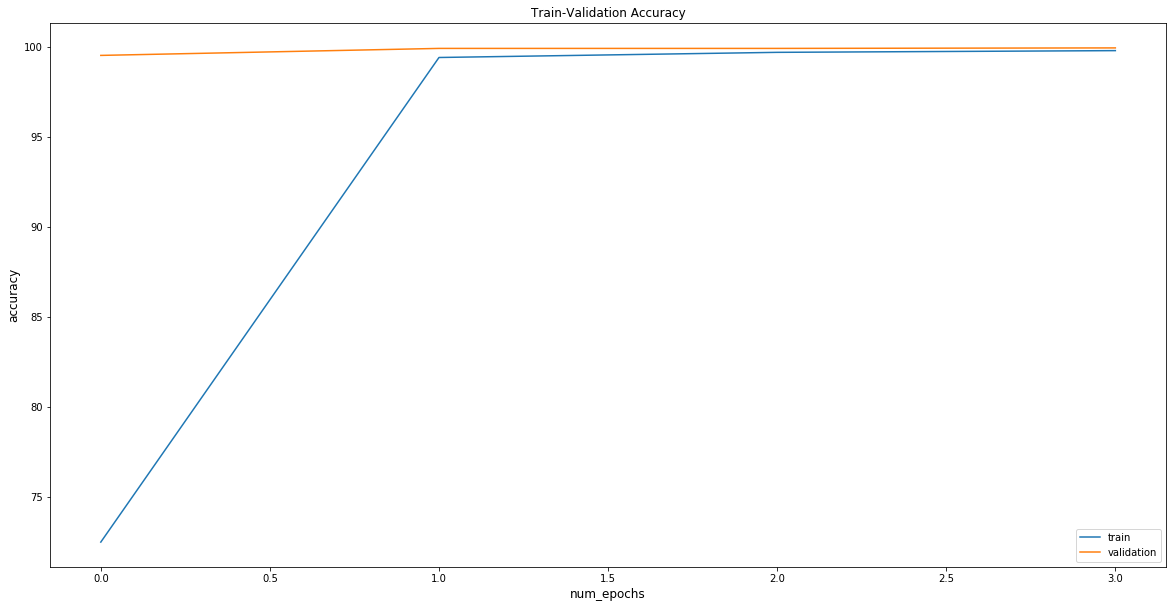

In [8]:
fig = plt.figure(figsize=(20, 10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')